# Analysis of Foursquare Data

# NYU - CUSP UDP Capstone
# Foursquare + NYC Merge by CT 
## Brief
This notebook 
1. Part I. Data Processing

    - import Foursquare data
    - imports the Census Tract shapefile
    - import Typologies
    - merges topologies
    - Spatail join by Census Tract
    - merges topologies
    - map topologies
    - map Businesses
1. Part II. Modeling
    - Performs a classifcation task on Typologies
###  You can refer to https://github.com/mv1742/updny_2

# Part I. Data Processing


In [85]:
import os
import requests
import shapely
import json

# !pip install pydotplus
from sklearn import tree
# from IPython.display import Image  
# import pydotplus

import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV



%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['linalg', 'Polygon', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Foursquare Data
- import Foursquare data

In [86]:
data = gpd.read_file('NYU_March2018_subset30.geojson')

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [87]:
(list(data.columns)), data.shape

(['id',
  'Place Name',
  'Rating',
  'Checkins',
  'Users',
  'Visits',
  'Pricing',
  'Type',
  'Category',
  'Class',
  'geometry'],
 (106287, 11))

In [88]:
data.head(1)

,id,Place Name,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class,geometry
0,50ad0afce4b0b4a7430e2268,Terry's Wine Shop,8.8,294,217,337,None,Wine Shop,Consumption,Optional,POINT (-74.00034036700906 40.73518392010902)


In [89]:
list(data.columns)[-4:-1]

['Type', 'Category', 'Class']

In [90]:
X_dummies = data[list(data.columns)[-4:-1]]
print(X_dummies.shape)
X_dummies = pd.get_dummies(X_dummies)
Fq_dummies = pd.concat([data, X_dummies], axis=1, join='inner')  
Fq_dummies.shape

(106287, 3)


(106287, 716)

# Census Tract shapefile
- imports the Census Tract shapefile


In [91]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /nfshome/mv1742/Capstone/udpny_2


In [92]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('TaxiData')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)


Master: /nfshome/mv1742/Capstone/udpny_2


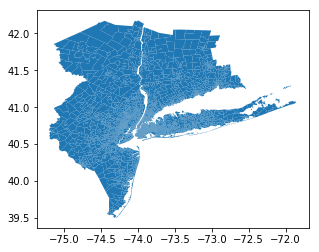

In [93]:
# url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
# NYCzip = getGeoDataFrameFromShpFileZipUrl(url)
NYCzip=gpd.read_file('Censustracts/region.shp')
NYCzip.plot()


In [94]:
NYCzip.columns

Index(['aland_mi', 'objectid', 'statefp', 'countyfp', 'tractce', 'geoid',
       'name', 'namelsad', 'mtfcc', 'funcstat', 'aland', 'awater', 'intptlat',
       'intptlon', 'shape_leng', 'shape_area', 'atotal', 'atotal_mi',
       'cartodb_id', 'geoid_1', 'hou16', 'hou16moe', 'hou16cv', 'houv16',
       'houv16moe', 'houv16cv', 'houo16', 'houo16moe', 'houo16cv', 'hour16',
       'hour16moe', 'hour16cv', 'emtot15', 'empr15', 'emoff15', 'emins15',
       'emind15', 'emser15', 'emoth15', 'geometry'],
      dtype='object')

In [95]:
NYCzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape
NYCzip.isnull().sum()

GEOID       0
geometry    0
dtype: int64

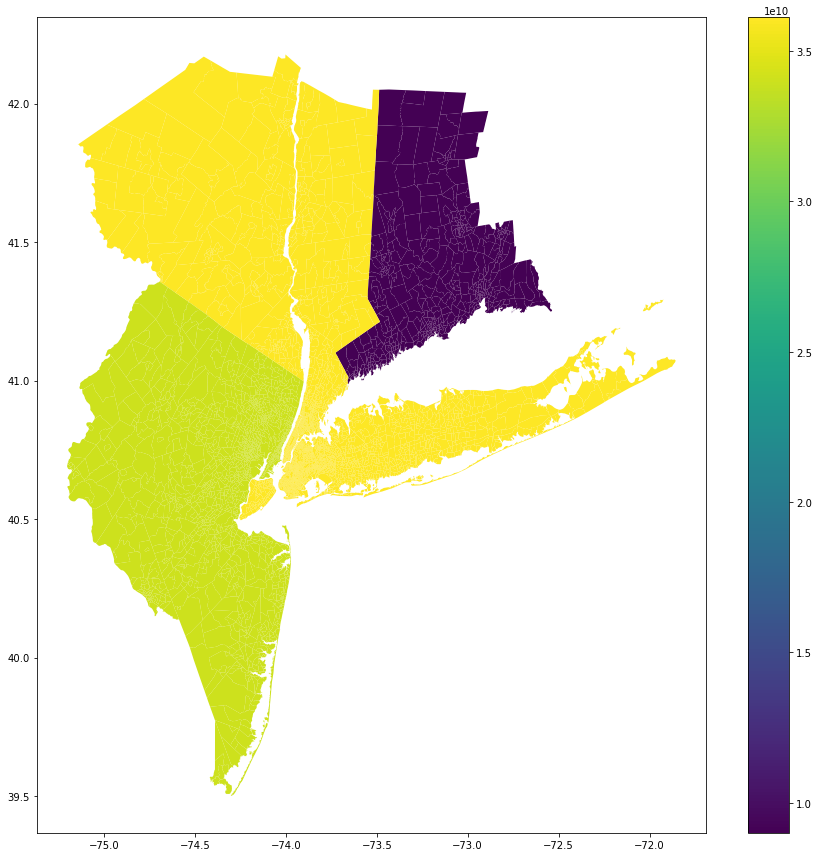

In [96]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzip.plot(column='GEOID',legend = True, ax=ax)

# Typologies
- import Typologies
- merges topologies
- map topologies

In [97]:

Typologiespd=pd.read_csv('NY_final_data_for_typologies_1.19.19.csv')
Typologiesgdp = gpd.GeoDataFrame(Typologiespd)
Typologiesgdp['Type_1.19'].replace('MHI - Advanced Exclusion','MHI - Ongoing Exclusion',inplace=True)
len(Typologiesgdp.columns)

82

In [98]:
Typologiesgdp.drop(columns = ['typology_old','Typology_final_1.19.19'], inplace=True)
list(Typologiesgdp.columns)

['geoid',
 'medrent90',
 'medrent00',
 'medrent16',
 'medhval90',
 'medhval00',
 'medhval16',
 'percol90',
 'percol00',
 'percol16',
 'pernwh90',
 'pernwh00',
 'pernwh16',
 'perli90',
 'perli00',
 'perli16',
 'per_rent_90',
 'per_rent_00',
 'per_rent16',
 'pop00',
 'pop16',
 'asian_16_low',
 'carcommuters_00',
 'pre50_16',
 'hhwch16',
 'empd15',
 'density16',
 'aland',
 'li16',
 'afford90',
 'belowmedcol90',
 'abovemednwh',
 'abovemedli',
 'abovemedrent',
 'vulnrisk90',
 'vuln90',
 'afford00',
 'belowmedcol00',
 'abovemednwh00',
 'abovemedli00',
 'abovemedrent00',
 'vulnrisk00',
 'vuln00',
 'afford16',
 'belowmedcol16',
 'abovemednwh16',
 'abovemedli16',
 'abovemedrent16',
 'vulnrisk16',
 'vuln16',
 'hotmarket90(127%-169%)',
 'hotmarket00(110%-207%)',
 'percol16.1',
 'edudiff0016',
 'abm_dif_0016',
 'edudiff9000',
 'abm_dif_9000',
 'hinc90_NYU',
 'hinc00_NYU',
 'hinc16_NYU',
 'hinc90',
 'hinc00',
 'hinc16',
 'pct_ch_hinc90_00',
 'pct_ch_hinc00_16',
 'abm_inc_90_00',
 'abm_inc_00_16',
 

In [99]:
Typologiesgdp.rename(columns={'geoid': "GEOID"},inplace=True)
Typologiesgdp.tail()
# cols_typ = ['GEOID','Type_1.19']
print(type(Typologiesgdp.iloc[:,0][0]))
#Typologies.rename(columns={'\ufeffgeoid': "GEOID"},inplace=True)
#Typologiesgdp.geoid = Typologies.iloc[:,0]
# Typologiesgdp = Typologiesgdp.loc[:,cols_typ]
Typologiesgdp.head()

<class 'numpy.float64'>


,GEOID,medrent90,medrent00,medrent16,medhval90,medhval00,medhval16,percol90,percol00,percol16,...,Type_1.19,ch_all_li_count90_00,ch_all_li_count00_16,liloss9016,per_limove16,per_limove09,exclusion,popgrowth0016,Incch0016,li_hh_16
0,9.001010e+09,1001.000000,1601.0,1510.0,500001.0000,1000001.0,1494000.0,0.516292,0.354071,0.619597,...,VHI - Super Gentrification or Exclusion,-19.55026245,136.0813599,0,0.6400990486,0.3994323015,0,0.0,0.5498838311,401.65921
1,9.001010e+09,1000.999968,1244.0,1628.0,500001.0059,1000000.0,2000000.0,0.619490,0.748477,0.784978,...,VHI - Super Gentrification or Exclusion,48.47680664,-7.125137329,0,0.4056389332,0.5011153221,1,0.0,0.8620689655,213.51843
2,9.001010e+09,1000.999996,833.0,2113.0,499472.1825,1000000.0,2000000.0,0.602177,0.704225,0.761389,...,VHI - Super Gentrification or Exclusion,-13.43575287,85.95057678,0,0.4642397463,0.3962181509,0,0.0,0.7325793103,180.98723
3,9.001010e+09,1001.000000,1791.0,2250.0,500001.0000,769300.0,1459900.0,0.552381,0.342164,0.662879,...,VHI - Super Gentrification or Exclusion,38.88369751,-84.88815308,0,0.3480436504,0.4504249096,1,1.0,1.192524372,363.08643
4,9.001010e+09,1001.000000,1967.0,1900.0,500001.0000,1000001.0,2000001.0,0.647751,0.357744,0.805446,...,VHI - Super Gentrification or Exclusion,-19.13200378,58.64305115,0,0.3950261176,0.4935227931,1,0.0,0.8974181129,310.05765


In [100]:
print(NYCzip.shape,Typologiesgdp.shape)
merged = NYCzip.merge(Typologiesgdp,on='GEOID')
print(type(merged),merged.shape)
merged.tail()

(5294, 2) (5298, 80)
<class 'geopandas.geodataframe.GeoDataFrame'> (5290, 81)


,GEOID,geometry,medrent90,medrent00,medrent16,medhval90,medhval00,medhval16,percol90,percol00,...,Type_1.19,ch_all_li_count90_00,ch_all_li_count00_16,liloss9016,per_limove16,per_limove09,exclusion,popgrowth0016,Incch0016,li_hh_16
5285,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,324.000003,533.000005,0.0,0.0000,0.0000,0.0,0.000095,0.134557,...,Missing Data,0.2853928208,-0.2856110036,0,0.6940270066,0.0005622510216,0,1.0,NaN,0.00000
5286,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,283.000000,461.000000,1184.0,NaN,392300.0000,NaN,0.075093,0.101382,...,LI - Ongoing Gentrification,60.11474609,268.1595459,0,0.496555984,0.65008986,1,1.0,1.501362508,1671.15310
5287,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",310.999994,427.000000,528.0,0.0000,625000.0000,0.0,0.055690,0.057858,...,LI - Ongoing Displacement of Low-Income Househ...,514.1179199,-57.55786133,0,0.719860971,0.5384375453,0,0.0,0.8618693201,1742.72380
5288,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,329.000000,582.000000,1196.0,187500.0000,175000.0000,537900.0,0.161512,0.171018,...,LI - Ongoing Gentrification,194.1737671,22.30535889,0,0.7885694504,0.5269782543,0,1.0,0.9512603314,662.92755
5289,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",554.271997,774.956522,1532.0,300142.2554,361840.6072,1146400.0,1.036555,0.422212,...,MHI - Stable or Early Stage of Exclusion,-76.31544495,30.12321472,0,0.6077033281,0.7516720891,1,1.0,1.007667239,284.00000


In [101]:
mergedgpd = gpd.GeoDataFrame(merged)
mergedgpd.shape

(5290, 81)

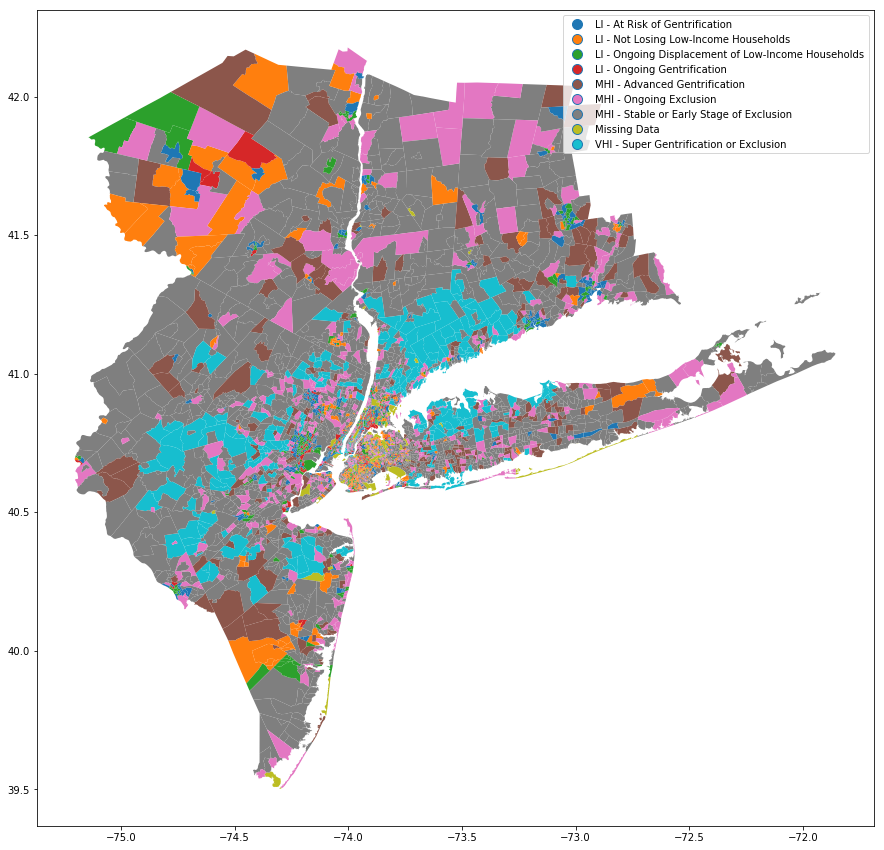

In [102]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='Type_1.19',legend = True, ax=ax)

## Select 90s and 2000s cols


In [103]:
len(mergedgpd.columns)

81

In [104]:
# Select 90s and 2000s cols
# Using pre-1990 regressors
cols_before90 = []
for column in mergedgpd.columns:
    if '90' in column:
        cols_before90.append(column)
cols_before90 
print(len(cols_before90),cols_before90 )


cols_00 = []
for column in mergedgpd.columns:
    if '00' in column:
        if '16' not in column:
            cols_00.append(column)

print(len(cols_00),cols_00 )

# importantcolssince90s = downloaded_input_only.append('GEOID')
# importantcolssince90s
cols_before00 = cols_before90 + cols_00
print(len(list(cols_before00)))
print(len(unique(cols_before00)))
cols_before00 = list(unique(cols_before00))

# importantcolssince90s = downloaded_input_only.append('GEOID')
# importantcolssince90s
cols_before00 = cols_before90 + cols_00
print(len(list(cols_before00)))
print(len(unique(cols_before00)))
cols_before00 = list(unique(cols_before00))
cols_before00


20 ['medrent90', 'medhval90', 'percol90', 'pernwh90', 'perli90', 'per_rent_90', 'afford90', 'belowmedcol90', 'vulnrisk90', 'vuln90', 'hotmarket90(127%-169%)', 'edudiff9000', 'abm_dif_9000', 'hinc90_NYU', 'hinc90', 'pct_ch_hinc90_00', 'abm_inc_90_00', 'gent90_00', 'ch_all_li_count90_00', 'liloss9016']
24 ['medrent00', 'medhval00', 'percol00', 'pernwh00', 'perli00', 'per_rent_00', 'pop00', 'carcommuters_00', 'afford00', 'belowmedcol00', 'abovemednwh00', 'abovemedli00', 'abovemedrent00', 'vulnrisk00', 'vuln00', 'hotmarket00(110%-207%)', 'edudiff9000', 'abm_dif_9000', 'hinc00_NYU', 'hinc00', 'pct_ch_hinc90_00', 'abm_inc_90_00', 'gent90_00', 'ch_all_li_count90_00']
44
38
44
38


['abm_dif_9000',
 'abm_inc_90_00',
 'abovemedli00',
 'abovemednwh00',
 'abovemedrent00',
 'afford00',
 'afford90',
 'belowmedcol00',
 'belowmedcol90',
 'carcommuters_00',
 'ch_all_li_count90_00',
 'edudiff9000',
 'gent90_00',
 'hinc00',
 'hinc00_NYU',
 'hinc90',
 'hinc90_NYU',
 'hotmarket00(110%-207%)',
 'hotmarket90(127%-169%)',
 'liloss9016',
 'medhval00',
 'medhval90',
 'medrent00',
 'medrent90',
 'pct_ch_hinc90_00',
 'per_rent_00',
 'per_rent_90',
 'percol00',
 'percol90',
 'perli00',
 'perli90',
 'pernwh00',
 'pernwh90',
 'pop00',
 'vuln00',
 'vuln90',
 'vulnrisk00',
 'vulnrisk90']

In [105]:
len(cols_before00)

38

In [106]:
# Reduce Census data to Foursquare Area

In [107]:
data_sjoined = gpd.sjoin(NYCzip,Fq_dummies, op="contains")
data_sjoined_sum = data_sjoined.groupby(by='GEOID').sum()

In [108]:
print(mergedgpd.shape,data_sjoined.shape)
mergedgpd = mergedgpd.merge(pd.DataFrame(data_sjoined_sum.reset_index().GEOID),on='GEOID')
mergedgpd.shape

(5290, 81) (105623, 718)


(3009, 81)

In [109]:
# Clean Data

In [110]:
print(mergedgpd.shape)
print(mergedgpd[cols_before00+['GEOID']].shape)
mergedgpd =  mergedgpd[['GEOID']+['Type_1.19']+['geometry']+cols_before00]
print(mergedgpd.shape)

(3009, 81)
(3009, 39)
(3009, 41)


In [111]:
mergedgpd.isnull().sum()

GEOID                       0
Type_1.19                   0
geometry                    0
abm_dif_9000               26
abm_inc_90_00               0
abovemedli00                0
abovemednwh00               0
abovemedrent00              0
afford00                    0
afford90                    0
belowmedcol00               0
belowmedcol90               0
carcommuters_00             0
ch_all_li_count90_00        6
edudiff9000                 0
gent90_00                  57
hinc00                     40
hinc00_NYU                517
hinc90                     44
hinc90_NYU                517
hotmarket00(110%-207%)     48
hotmarket90(127%-169%)     44
liloss9016                  0
medhval00                  66
medhval90                 314
medrent00                  45
medrent90                  39
pct_ch_hinc90_00           84
per_rent_00                47
per_rent_90                 1
percol00                    0
percol90                    0
perli00                     0
perli90   

In [112]:
print(type(mergedgpd.hinc00_NYU[8]))
print(type(np.nan))
# Note that mergedgpd.hinc00_NYU[8] == np.nan >>> False
# np.float64(nan)

# float('nan')
np.isnan(mergedgpd.iloc[9,19])

<class 'numpy.float64'>
<class 'float'>


True

In [113]:
# mergedgpd['abm_inc_90_00']

In [114]:
# #identify nans
# for k, column in enumerate(mergedgpd.drop(['Type_1.19','GEOID','geometry'],axis =1).columns):    


In [115]:
print(mergedgpd.shape)
for k, column in enumerate(mergedgpd.drop(['Type_1.19','GEOID','geometry'],axis =1).columns):
    mergedgpd[column].replace(False,0, inplace=True)
    mergedgpd[column].replace('FALSE',0, inplace=True)
    mergedgpd[column].replace('#NULL!',np.nan, inplace=True)
    mergedgpd[column] = pd.to_numeric(mergedgpd[column])
    for i in mergedgpd[column].index:
        if mergedgpd.loc[i,column] == '#NULL!':
            print('#NULL',i)
            mergedgpd['new_'+column] = 0
        if np.isnan(mergedgpd.loc[i,column]):
            print('nan',i)
            mergedgpd['new_'+column] = 0
    for i in mergedgpd[column].index:
        if np.isnan(mergedgpd.loc[i,column]):
            print('nan')
            mergedgpd.loc[i,'new_'+column] = 1

#     try:
#         mergedgpd[column] = pd.to_numeric(mergedgpd[column])
#     except:
#     for i in mergedgpd[column].index:
#         if mergedgpd.iloc[i,k] == '#NULL!':
#             print(mergedgpd.iloc[i,k])
#             print("!!NULL!!")
    print(column)
    mergedgpd[column] = pd.to_numeric(mergedgpd[column])
    mergedgpd[column].replace(nan,mean(mergedgpd[column]), inplace=True)
    

# X_foursquare.replace(False,0,inplace=True)
# X_foursquare.replace('FALSE',0,inplace=True)
# X_foursquare.replace('#NULL!',0,inplace=True)
# X_foursquare.replace(nan,0,inplace=True)

mergedgpd.dropna(inplace=True)
mergedgpd.shape

(3009, 41)
nan 104
nan 393
nan 939
nan 1295
nan 1308
nan 1323
nan 1407
nan 1556
nan 1763
nan 2040
nan 2215
nan 2230
nan 2297
nan 2317
nan 2360
nan 2435
nan 2437
nan 2448
nan 2461
nan 2517
nan 2528
nan 2555
nan 2697
nan 2728
nan 2820
nan 2841
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
abm_dif_9000
abm_inc_90_00
abovemedli00
abovemednwh00
abovemedrent00
afford00
afford90
belowmedcol00
belowmedcol90
carcommuters_00
nan 94
nan 104
nan 134
nan 393
nan 938
nan 939
nan 1271
nan 1295
nan 1308
nan 1323
nan 1407
nan 1490
nan 1556
nan 1594
nan 1695
nan 1697
nan 1763
nan 1791
nan 2040
nan 2140
nan 2180
nan 2215
nan 2230
nan 2297
nan 2317
nan 2360
nan 2410
nan 2435
nan 2437
nan 2448
nan 2461
nan 2517
nan 2528
nan 2555
nan 2572
nan 2583
nan 2673
nan 2697
nan 2728
nan 2807
nan 2820
nan 2841
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
hinc00_NYU
nan 94
nan 104
nan 134
nan 393
nan 938
nan 939
nan 1271
nan 1295
nan 1308
nan 1323
nan 1349
nan 1407
nan 1490
nan 1556
nan 1594
nan 1695
nan 1697
nan 1763
nan 1791
nan 1828
nan 2040
nan 2140
nan 2180
nan 2215
nan 2230
nan 2297
nan 2317
nan 2360
nan 2410
nan 2435
nan 2437
nan 2448
nan 2461
nan 2517
nan 2528
nan 2555
nan 2572
nan 2673
nan 2697
nan 2728
nan 2807
nan 2820
nan 2841
nan 2860
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
hinc90
nan 2
nan 8
nan 9
nan 15
nan 16
nan 19
nan 20
nan 21
nan 25
nan 33
nan 35
nan 37
nan 42
nan 43
nan 49
nan 57
nan 60
nan 61
nan 76
nan 87
nan 92
nan 94
nan 104
nan 113
nan 115
nan 116
nan 119
nan 134
nan 146
nan 162
nan 170
nan 186
nan 206
nan 213
nan 215
nan 216
nan 217
nan 218
nan 219
nan 220
nan 222
nan 23

nan 1271
nan 1295
nan 1308
nan 1323
nan 1349
nan 1393
nan 1407
nan 1556
nan 1639
nan 1688
nan 1695
nan 1763
nan 1828
nan 2040
nan 2140
nan 2180
nan 2215
nan 2230
nan 2264
nan 2297
nan 2317
nan 2360
nan 2410
nan 2435
nan 2437
nan 2448
nan 2461
nan 2517
nan 2528
nan 2555
nan 2572
nan 2576
nan 2583
nan 2588
nan 2625
nan 2673
nan 2697
nan 2728
nan 2820
nan 2841
nan 2860
nan 2953
nan 2981
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
liloss9016
nan 29
nan 51
nan 94
nan 104
nan 110
nan 134
nan 151
nan 223
nan 229
nan 393
nan 426
nan 920
nan 927
nan 939
nan 1295
nan 1308
nan 1323
nan 1349
nan 1407
nan 1432
nan 1556
nan 1560
nan 1578
nan 1619
nan 1695
nan 1763
nan 1828
nan 1969
nan 2040
nan 2056
nan 2101
nan 2128
nan 2140
nan 2151
nan 2180
nan 2201
nan 2215
nan 2230
nan 2261
nan 2271
nan 2277
nan 2289
nan 2292
nan 2296
nan 2297
na

nan 2264
nan
per_rent_90
percol00
percol90
perli00
perli90
pernwh00
pernwh90
pop00
nan 104
nan 393
nan 938
nan 939
nan 1295
nan 1308
nan 1323
nan 1407
nan 1556
nan 1594
nan 1697
nan 1763
nan 1791
nan 2040
nan 2215
nan 2230
nan 2297
nan 2317
nan 2360
nan 2435
nan 2437
nan 2448
nan 2461
nan 2517
nan 2528
nan 2555
nan 2697
nan 2728
nan 2807
nan 2820
nan 2841
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
vuln00
vuln90
vulnrisk00
vulnrisk90


(3009, 59)

In [116]:
mergedgpd.isnull().sum()

GEOID                         0
Type_1.19                     0
geometry                      0
abm_dif_9000                  0
abm_inc_90_00                 0
abovemedli00                  0
abovemednwh00                 0
abovemedrent00                0
afford00                      0
afford90                      0
belowmedcol00                 0
belowmedcol90                 0
carcommuters_00               0
ch_all_li_count90_00          0
edudiff9000                   0
gent90_00                     0
hinc00                        0
hinc00_NYU                    0
hinc90                        0
hinc90_NYU                    0
hotmarket00(110%-207%)        0
hotmarket90(127%-169%)        0
liloss9016                    0
medhval00                     0
medhval90                     0
medrent00                     0
medrent90                     0
pct_ch_hinc90_00              0
per_rent_00                   0
per_rent_90                   0
percol00                      0
percol90

In [117]:
# print(mergedgpd.shape)

# for k, column in enumerate(mergedgpd.drop(['Type_1.19','GEOID','geometry'],axis =1).columns):
    
#     for i in mergedgpd[column].index:
#         if np.isnan(mergedgpd.loc[i,column]):
#             print('nan')
#             mergedgpd.loc[i,'new_'+column] = 1

# #     try:
# #         mergedgpd[column] = pd.to_numeric(mergedgpd[column])
# #     except:
# #     for i in mergedgpd[column].index:
# #         if mergedgpd.iloc[i,k] == '#NULL!':
# #             print(mergedgpd.iloc[i,k])
# #             print("!!NULL!!")
#     print(column)
#     mergedgpd[column] = pd.to_numeric(mergedgpd[column])
#     mergedgpd[column].replace(nan,mean(mergedgpd[column]), inplace=True)
    

# # X_foursquare.replace(False,0,inplace=True)
# # X_foursquare.replace('FALSE',0,inplace=True)
# # X_foursquare.replace('#NULL!',0,inplace=True)
# # X_foursquare.replace(nan,0,inplace=True)

# mergedgpd.dropna(inplace=True)
# mergedgpd.shape

In [118]:
# mergedgpd['new_hinc00_NYU'].sum()

In [119]:
mergedgpd.isnull().sum()

GEOID                         0
Type_1.19                     0
geometry                      0
abm_dif_9000                  0
abm_inc_90_00                 0
abovemedli00                  0
abovemednwh00                 0
abovemedrent00                0
afford00                      0
afford90                      0
belowmedcol00                 0
belowmedcol90                 0
carcommuters_00               0
ch_all_li_count90_00          0
edudiff9000                   0
gent90_00                     0
hinc00                        0
hinc00_NYU                    0
hinc90                        0
hinc90_NYU                    0
hotmarket00(110%-207%)        0
hotmarket90(127%-169%)        0
liloss9016                    0
medhval00                     0
medhval90                     0
medrent00                     0
medrent90                     0
pct_ch_hinc90_00              0
per_rent_00                   0
per_rent_90                   0
percol00                      0
percol90

# Ignore Foursquare Data
# Spatail Join
- Spatail join by Census Tract
- map Businesses


In [120]:
mergedgpd.crs, data.crs, mergedgpd.shape, data.shape

(None, {'init': 'epsg:4326'}, (3009, 59), (106287, 11))

In [121]:
mergedgpd.crs = {'init' :'epsg:4326'}

In [122]:
mergedgpd.crs

{'init': 'epsg:4326'}

In [123]:
data_sjoined = gpd.sjoin(mergedgpd,Fq_dummies, op="contains")

In [124]:
list(data_sjoined.columns)

['GEOID',
 'Type_1.19',
 'geometry',
 'abm_dif_9000',
 'abm_inc_90_00',
 'abovemedli00',
 'abovemednwh00',
 'abovemedrent00',
 'afford00',
 'afford90',
 'belowmedcol00',
 'belowmedcol90',
 'carcommuters_00',
 'ch_all_li_count90_00',
 'edudiff9000',
 'gent90_00',
 'hinc00',
 'hinc00_NYU',
 'hinc90',
 'hinc90_NYU',
 'hotmarket00(110%-207%)',
 'hotmarket90(127%-169%)',
 'liloss9016',
 'medhval00',
 'medhval90',
 'medrent00',
 'medrent90',
 'pct_ch_hinc90_00',
 'per_rent_00',
 'per_rent_90',
 'percol00',
 'percol90',
 'perli00',
 'perli90',
 'pernwh00',
 'pernwh90',
 'pop00',
 'vuln00',
 'vuln90',
 'vulnrisk00',
 'vulnrisk90',
 'new_abm_dif_9000',
 'new_ch_all_li_count90_00',
 'new_gent90_00',
 'new_hinc00',
 'new_hinc00_NYU',
 'new_hinc90',
 'new_hinc90_NYU',
 'new_hotmarket00(110%-207%)',
 'new_hotmarket90(127%-169%)',
 'new_liloss9016',
 'new_medhval00',
 'new_medhval90',
 'new_medrent00',
 'new_medrent90',
 'new_pct_ch_hinc90_00',
 'new_per_rent_00',
 'new_per_rent_90',
 'new_vuln00',


In [125]:
data_sjoined_sum = data_sjoined.groupby(by='GEOID').sum()
print(data_sjoined_sum.shape,data_sjoined_sum.columns)
data_sjoined_sum_merged = data_sjoined_sum.merge(mergedgpd.loc[:,['GEOID','Type_1.19', 'geometry']],on='GEOID')
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)
data_sjoined_sum_merged = gpd.GeoDataFrame(data_sjoined_sum_merged)
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)

(3009, 766) Index(['abm_dif_9000', 'abm_inc_90_00', 'abovemedli00', 'abovemednwh00',
       'abovemedrent00', 'afford00', 'afford90', 'belowmedcol00',
       'belowmedcol90', 'carcommuters_00',
       ...
       'Category_Leisure', 'Category_Mobility', 'Category_Nutrition',
       'Category_Personal care', 'Category_Social', 'Category_Taking care',
       'Category_Unknown', 'Class_', 'Class_Necessary', 'Class_Optional'],
      dtype='object', length=766)
(3009, 769) Index(['GEOID', 'abm_dif_9000', 'abm_inc_90_00', 'abovemedli00',
       'abovemednwh00', 'abovemedrent00', 'afford00', 'afford90',
       'belowmedcol00', 'belowmedcol90',
       ...
       'Category_Nutrition', 'Category_Personal care', 'Category_Social',
       'Category_Taking care', 'Category_Unknown', 'Class_', 'Class_Necessary',
       'Class_Optional', 'Type_1.19', 'geometry'],
      dtype='object', length=769)
(3009, 769) Index(['GEOID', 'abm_dif_9000', 'abm_inc_90_00', 'abovemedli00',
       'abovemednwh00', 'abov

In [126]:
Fq_dummies.shape,data_sjoined_sum_merged.shape, len(data_sjoined_sum_merged.GEOID.unique())

((106287, 716), (3009, 769), 3009)

In [127]:
data_sjoined_sum_merged.rename(columns={"Type_1.19": "Typologies"}, inplace = True)

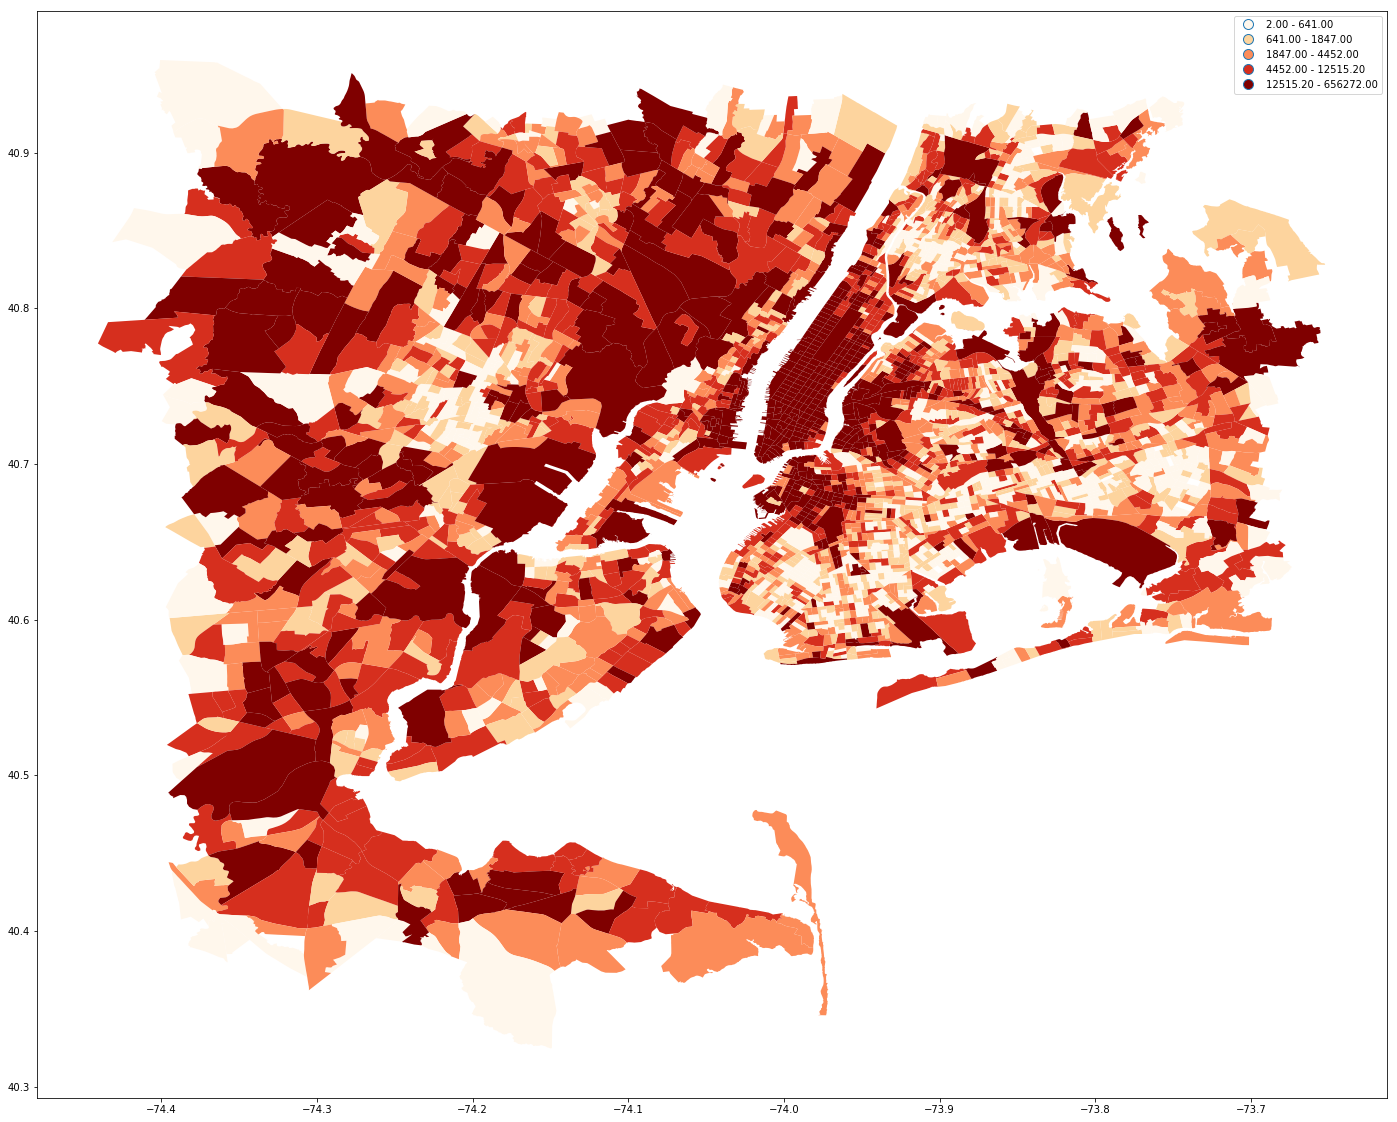

In [128]:
plt.rcParams['figure.figsize'] = (30, 20)
ax = data_sjoined_sum_merged.plot(column='Checkins', scheme='quantiles', cmap='OrRd', legend=True)

In [129]:
data_sjoined_sum_merged.isnull().sum()

GEOID                      0
abm_dif_9000               0
abm_inc_90_00              0
abovemedli00               0
abovemednwh00              0
abovemedrent00             0
afford00                   0
afford90                   0
belowmedcol00              0
belowmedcol90              0
carcommuters_00            0
ch_all_li_count90_00       0
edudiff9000                0
gent90_00                  0
hinc00                     0
hinc00_NYU                 0
hinc90                     0
hinc90_NYU                 0
hotmarket00(110%-207%)     0
hotmarket90(127%-169%)     0
liloss9016                 0
medhval00                  0
medhval90                  0
medrent00                  0
medrent90                  0
pct_ch_hinc90_00           0
per_rent_00                0
per_rent_90                0
percol00                   0
percol90                   0
                          ..
Type_Waterfall             0
Type_Waterfront            0
Type_Wedding Hall          0
Type_Weight Lo

In [130]:
len(list(mergedgpd.columns))


59

In [131]:
list(data_sjoined_sum_merged.iloc[:,50:70])

['new_medhval90',
 'new_medrent00',
 'new_medrent90',
 'new_pct_ch_hinc90_00',
 'new_per_rent_00',
 'new_per_rent_90',
 'new_vuln00',
 'index_right',
 'Rating',
 'Checkins',
 'Users',
 'Visits',
 'Type_ATM',
 'Type_Accessories Store',
 'Type_Acupuncturist',
 'Type_Adult Boutique',
 'Type_Adult Education Center',
 'Type_Advertising Agency',
 'Type_Afghan Restaurant',
 'Type_African Restaurant']

In [132]:
data_sjoined_sum_merged = data_sjoined_sum_merged[list(data_sjoined_sum_merged.iloc[:,:58].columns)+['Typologies','GEOID','geometry']]


In [133]:
data_sjoined_sum_merged.columns

Index(['GEOID', 'abm_dif_9000', 'abm_inc_90_00', 'abovemedli00',
       'abovemednwh00', 'abovemedrent00', 'afford00', 'afford90',
       'belowmedcol00', 'belowmedcol90', 'carcommuters_00',
       'ch_all_li_count90_00', 'edudiff9000', 'gent90_00', 'hinc00',
       'hinc00_NYU', 'hinc90', 'hinc90_NYU', 'hotmarket00(110%-207%)',
       'hotmarket90(127%-169%)', 'liloss9016', 'medhval00', 'medhval90',
       'medrent00', 'medrent90', 'pct_ch_hinc90_00', 'per_rent_00',
       'per_rent_90', 'percol00', 'percol90', 'perli00', 'perli90', 'pernwh00',
       'pernwh90', 'pop00', 'vuln00', 'vuln90', 'vulnrisk00', 'vulnrisk90',
       'new_abm_dif_9000', 'new_ch_all_li_count90_00', 'new_gent90_00',
       'new_hinc00', 'new_hinc00_NYU', 'new_hinc90', 'new_hinc90_NYU',
       'new_hotmarket00(110%-207%)', 'new_hotmarket90(127%-169%)',
       'new_liloss9016', 'new_medhval00', 'new_medhval90', 'new_medrent00',
       'new_medrent90', 'new_pct_ch_hinc90_00', 'new_per_rent_00',
       'new_per_ren

# Part II. Modeling
### Analysis ## FOURSQUARE

In [154]:
X_foursquare = data_sjoined_sum_merged.drop(['Typologies','GEOID','geometry','index_right'],axis =1).copy()
X_foursquare.shape

(3009, 56)

In [155]:
X_foursquare.columns

Index(['abm_dif_9000', 'abm_inc_90_00', 'abovemedli00', 'abovemednwh00',
       'abovemedrent00', 'afford00', 'afford90', 'belowmedcol00',
       'belowmedcol90', 'carcommuters_00', 'ch_all_li_count90_00',
       'edudiff9000', 'gent90_00', 'hinc00', 'hinc00_NYU', 'hinc90',
       'hinc90_NYU', 'hotmarket00(110%-207%)', 'hotmarket90(127%-169%)',
       'liloss9016', 'medhval00', 'medhval90', 'medrent00', 'medrent90',
       'pct_ch_hinc90_00', 'per_rent_00', 'per_rent_90', 'percol00',
       'percol90', 'perli00', 'perli90', 'pernwh00', 'pernwh90', 'pop00',
       'vuln00', 'vuln90', 'vulnrisk00', 'vulnrisk90', 'new_abm_dif_9000',
       'new_ch_all_li_count90_00', 'new_gent90_00', 'new_hinc00',
       'new_hinc00_NYU', 'new_hinc90', 'new_hinc90_NYU',
       'new_hotmarket00(110%-207%)', 'new_hotmarket90(127%-169%)',
       'new_liloss9016', 'new_medhval00', 'new_medhval90', 'new_medrent00',
       'new_medrent90', 'new_pct_ch_hinc90_00', 'new_per_rent_00',
       'new_per_rent_90', 'n

In [156]:
# type(X_foursquare['abovemedrent00'][200])

In [157]:
y = data_sjoined_sum_merged.Typologies

In [158]:
# for column in X_foursquare.columns:
#     print(X_foursquare[column].isnull().sum())

In [159]:
### Preprocessing Data

## change to zeros

# replace with mean/median

# create a new

print(X_foursquare.shape)
for k, column in enumerate(X_foursquare.columns):
    X_foursquare[column].replace(False,0, inplace=True)
    X_foursquare[column].replace('FALSE',0, inplace=True)

# X_foursquare.replace(False,0,inplace=True)
# X_foursquare.replace('FALSE',0,inplace=True)
# X_foursquare.replace('#NULL!',0,inplace=True)
# X_foursquare.replace(nan,0,inplace=True)

X_foursquare.dropna(inplace=True)
print(X_foursquare.shape)

(3009, 56)
(3009, 56)


In [173]:
R2 = {}
model = {}
modelslist = ['Logit','DT','RF','SVM'] 

In [161]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_foursquare, y, test_size = 0.3, random_state = 1)    

In [162]:
# ### Notes Meeting with TA.

# 1. Change mean with Nans, and add a new column with 1.

# - Logistic Reg should be our baseline...

# Other possible models:
# - kNN
# - Boosting


# Explore relationship between columns... one column times the other = one additional feature
# Use pd.scatter to explore data. It shows the distribution between one column to the other - e.g. histogram

In [163]:
# LR

In [164]:
## Logistic Reeg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
import matplotlib.pylab
%pylab inline
logit_1 = LogisticRegression(C = 10000)
print(X_train.shape,y_train.shape)
logit_1.fit(X_train, y_train)
print(logit_1.score(X_test,y_test))
model['Logit'] = logit_1.score(X_test,y_test)

Populating the interactive namespace from numpy and matplotlib
(2106, 56) (2106,)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.33665559247


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [165]:
#DT

In [166]:
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.
from sklearn.tree import DecisionTreeClassifier
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.
param_grid = {'max_depth':range(1,11),'max_leaf_nodes':range(2,11)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid,scoring='accuracy')
ds=gr.fit(X_train,y_train)
print (ds.best_params_)

model['DT'] = gr.score(X_test,y_test)
model

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_leaf_nodes': 10, 'max_depth': 4}


{'DT': 0.52934662236987817, 'Logit': 0.33665559246954596}

# Random Forest

In [167]:
# with census data

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

param_grid = {'max_depth':range(1,11),'n_estimators':range(1,11),'max_leaf_nodes':range(2,11)}
rf=RandomForestClassifier()
gr=GridSearchCV(rf,param_grid=param_grid,scoring='accuracy')
rs=gr.fit(X_train,y_train)
print (rs.best_params_)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_leaf_nodes': 10, 'max_depth': 10, 'n_estimators': 9}


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [169]:
seed = 5
print(y_train.shape, X_train.shape)

OS = []
for c in range(5):

    rf=RandomForestClassifier()

    rf = RandomForestClassifier(max_depth=rs.best_params_['max_depth'],max_leaf_nodes=rs.best_params_['max_leaf_nodes'])
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)[:,1]
    OS.append(rf.score(X_test,y_test))
    
print(rf.score(X_test,y_test))
model['RF'] = mean(OS)
model

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0

(2106,) (2106, 56)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.528239202658


{'DT': 0.52934662236987817,
 'Logit': 0.33665559246954596,
 'RF': 0.52978959025470651}

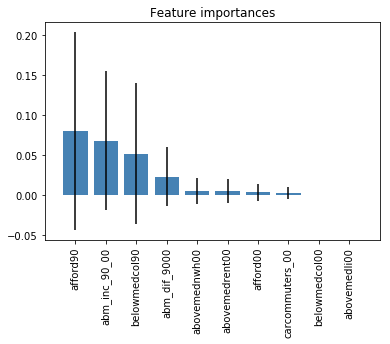

In [170]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_[:10]
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()
featureImportancePlot(rf, X_foursquare.columns)

# SVM

In [171]:
from sklearn.model_selection import GridSearchCV

# When C is very small, we are willing to tolerate more mistakes. If C is very big, this
# means we hardly tolerate any mistakes. So, we cannot choose a very large C if our data is not
# really separable. Let's however choose from a broad range of reasonable options.
# param_grid = {'kernel':['linear'],'C':[np.exp(i) for i in np.linspace(-10,10,10)]}
OS = []
for c in range(5):
    rr = svm.SVC()
#     gr=GridSearchCV(rr,param_grid=param_grid)
    rr.fit(X_train, y_train)
#     print(rr.best_estimator_)
    correct=1.0*(rr.predict(X_test)==np.asarray(y_test)).sum()/len(y_test)
    
    OS.append(correct)
model['SVM'] = mean(OS)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

In [174]:
for i in modelslist:
    print(i)
for i in modelslist:
    print(model[i])
model.keys(), model.values()

Logit
DT
RF
SVM
0.33665559247
0.52934662237
0.529789590255
0.285714285714


(dict_keys(['Logit', 'SVM', 'DT', 'RF']),
 dict_values([0.33665559246954596, 0.2857142857142857, 0.52934662236987817, 0.52978959025470651]))

# Output
- outputs a .csv of the results
- You can refer to https://github.com/mv1742/updny_2

In [153]:
### with additional column ['MEANS FOR NANS'!]
0.34219269103
0.285714285714
0.509413067553
0.490586932447

0.490586932447